# Fake News Classification using LSTM with GloVe Embeddings

## 1.About Dataset

The goal of this project is to classify news articles as either real or fake.
This dataset consists of 44919 news articles with 21417 real and 23502 fake news.

**Dataset separated in two files:**

Fake.csv (23502 fake news article)<br>
True.csv (21417 true news article)<br>

**Dataset columns:**

Title: title of news article<br>
Text: body text of news article<br>
Subject: subject of news article<br>
Date: publish date of news article<br>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, classification_report

# Natual Language Processing
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Flatten, Dense, Dropout, Bidirectional, Input, GlobalMaxPooling1D

In [2]:
path_fake_data = "/kaggle/input/fake-and-real-news-dataset/Fake.csv"
path_true_data = "/kaggle/input/fake-and-real-news-dataset/True.csv"

fake_news = pd.read_csv(path_fake_data)
true_news = pd.read_csv(path_true_data)

## 2.Exploratory Data Analysis

### Data Preview

In [3]:
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
# Print Fake news as an example

print('title: {}\n'.format(fake_news.title[3]))
print(fake_news.text[3])

title:  Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)

On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trum

In [6]:
fake_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


In [7]:
true_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [8]:
# Labeling
true_news["target"] = 1
fake_news["target"] = 0

In [9]:
# Combine two Data Frames
df = pd.concat([true_news, fake_news], ignore_index = True)
df.sample(5)

,title,text,subject,date,target
23501,BREAKING: Comey Just Shut Down Trump’s Tweete...,"On Monday, while FBI Director James Comey and ...",News,"March 20, 2017",0
8490,Trump seeks to raise fresh ethical questions a...,"FORT LAUDERDALE, Fla. (Reuters) - Republican p...",politicsNews,"August 11, 2016",1
18389,Defense Secretary Mattis suggests sticking wit...,WASHINGTON (Reuters) - U.S. Defense Secretary ...,worldnews,"October 3, 2017",1
8615,No plans to release tax returns as pressure mo...,(Reuters) - Republican presidential candidate ...,politicsNews,"July 27, 2016",1
8056,Trump vs. Clinton: Debate will mark biggest mo...,WASHINGTON (Reuters) - Democrat Hillary Clinto...,politicsNews,"September 22, 2016",1


In [10]:
# The number of words in each text
text_length = df['text'].str.split().str.len()
text_length.describe()

count    44898.000000
mean       405.282284
std        351.265595
min          0.000000
25%        203.000000
50%        362.000000
75%        513.000000
max       8135.000000
Name: text, dtype: float64

### Preprocess for Natural Language

In [11]:
# Download stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
# Preprocess function
def preprocess_text(text):
    
    # Tokenize
    words = word_tokenize(text.lower())
    
    # Remove stop words
    stop_words = set(stopwords.words('english'))
    custom_stopwords = {}
    all_stopwords = stop_words.union(custom_stopwords)
    
    words = [word for word in words if word.isalnum() and word not in all_stopwords]
    
    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    return ' '.join(words)

In [13]:
# Remove URL
import re
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)

In [14]:
# Apply the preprocessing function
df['processed'] = df.text.apply(preprocess_text)
df.processed = df.processed.apply(remove_URL)
df.head()

,title,text,subject,date,target,processed
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow first ...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,reuter presid donald trump call postal servic ...


In [15]:
# Print Fake news as an example

print('title: {}\n'.format(df.title[3]))
print(df.processed[3])

title: FBI Russia probe helped by Australian diplomat tip-off: NYT

washington reuter trump campaign advis georg papadopoulo told australian diplomat may 2016 russia polit dirt democrat presidenti candid hillari clinton new york time report saturday convers papadopoulo diplomat alexand downer london drive factor behind fbi decis open investig moscow contact trump campaign time report two month meet australian offici pass inform came papadopoulo american counterpart leak democrat email began appear onlin accord newspap cite four current former foreign offici besid inform australian probe feder bureau investig also propel intellig friendli govern includ british dutch time said papadopoulo intern energi lawyer plead guilti 30 lie fbi agent contact peopl claim tie top russian offici first crimin charg alleg link trump campaign russia white hous play former aid campaign role say extrem limit action took would new york time howev report papadopoulo help set meet donald trump egyptian presid 

### Word Cloud

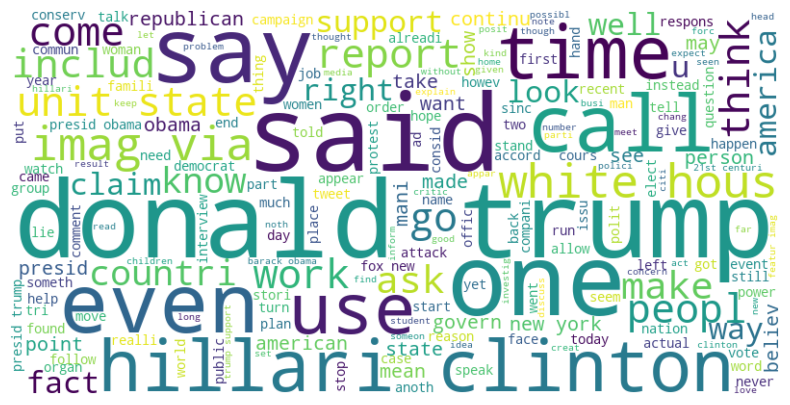

In [16]:
# In the case of Fake News
from wordcloud import WordCloud

text_all = ' '.join(df[df.target == 0].processed)

# Create WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white').generate(text_all)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

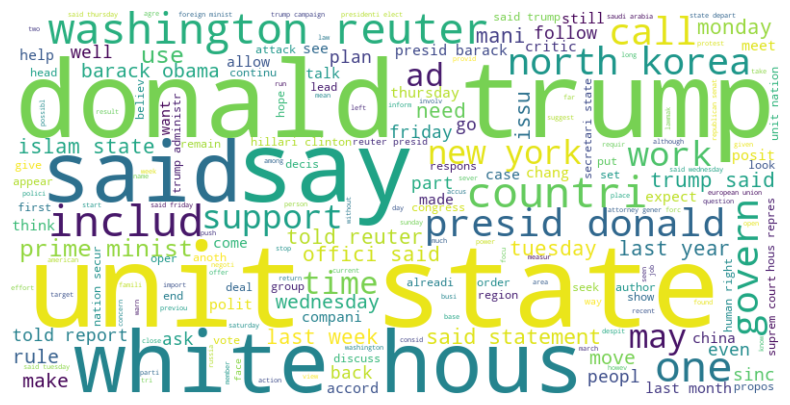

In [17]:
# In the case of Real News

text_all = ' '.join(df[df.target == 1].processed)

# Create WordCloud
wordcloud = WordCloud(width=800,
                      height=400,
                      background_color='white').generate(text_all)

# Show WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### The Most common words

In [18]:
# Count unique words
from collections import Counter

def counter_word(text_col):
  count = Counter()
  for text in text_col.values:
    for word in text.split():
      count[word] += 1
  return count

# The number of unique words
counter = counter_word(df.processed)
num_unique_words = len(counter)
num_unique_words

82442

In [19]:
counter.most_common(10)

[('said', 130180),
 ('trump', 128715),
 ('state', 60313),
 ('presid', 56417),
 ('would', 54987),
 ('peopl', 41301),
 ('republican', 38166),
 ('one', 36833),
 ('say', 36568),
 ('year', 33561)]

## 3.Tokenize and Padding

In [20]:
# Split the data
from sklearn.model_selection import train_test_split
X = df.processed
y = df.target

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [21]:
# Tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

# Vectorize a text corpus by turning each text into a sequence of integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [22]:
word_index = tokenizer.word_index

# 5 samples of word_index
import random
random_keys = random.sample(list(word_index.keys()), 5)
for key in random_keys:
  print(f"key: {key}, value: {word_index[key]}")

key: kolenda, value: 33228
key: convoy, value: 3569
key: antiretrovir, value: 71002
key: displac, value: 2847
key: brak, value: 47810


### Convert text data to sequences

In [23]:
# Convert text data to sequences
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_val_sequences = tokenizer.texts_to_sequences(X_val)

# An example
print(X_train[1])
print(X_train_sequences[1])

washington reuter transgend peopl allow first time enlist militari start monday order feder court pentagon said friday presid donald trump administr decid appeal rule block transgend ban two feder appeal court one washington one virginia last week reject administr request put hold order lower court judg requir militari begin accept transgend recruit justic depart offici said administr challeng rule depart defens announc releas independ studi issu come week rather litig interim appeal occur administr decid wait dod studi continu defend presid law author district court meantim offici said speak condit anonym septemb pentagon said creat panel senior offici studi implement direct trump prohibit transgend individu serv defens depart 21 submit plan trump lawyer repres transgend servic member aspir recruit said expect administr appeal rule suprem court hope would happen pentagon spokeswoman heather babb said statement mandat court order depart defens prepar begin access transgend applic milit

### Padding

In [24]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Max number of words in a sequence
max_length = 500
embedding_dim = 300

X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length,
                               padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length,
                             padding="post", truncating="post")

## 4.Build the RNN model with GloVe Embeddings

**GloVe** (Global Vectors for Word Representation) aims to capture the semantic meaning of words by considering the global statistics of a corpus—how often words appear together. This pre-trained word embedding is learned from vast amounts of diverse text data, so they encode rich semantic information that can help improve the performance of downstream tasks, especially when we have limited training data for the task at hand.

In [25]:
glove_emb = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'

embedding_dim = 300
embeddings_index = {}

f = open(glove_emb)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index)+1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Convert the integer-encoded labels into One-hot encoding

In [26]:
y_train_one_hot = tf.keras.utils.to_categorical(y_train)
y_val_one_hot = tf.keras.utils.to_categorical(y_val)

In [27]:
# Parameters
epochs = 10
lr = 0.0001

# Model
model = Sequential()

model.add(Input(shape=(max_length,)))
model.add(Embedding(len(word_index) + 1, embedding_dim,
                    input_length = max_length, trainable = False))

model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid')) # Dence = 2 because of One-hot encodings

# Set the GloVe embedding weights
model.layers[0].set_weights([embedding_matrix])

# Compile the model
from tensorflow.keras.optimizers import Adam
model.compile(optimizer = Adam(learning_rate = lr), 
              loss = "binary_crossentropy", metrics = ['accuracy'])

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 500, 300)       │    22,515,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 500, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,152,486 (88.32 MB)

 Trainable params: 637,186 (2.43 MB)

 Non-trainable params: 22,515,300 (85.89 MB)

In [28]:
%%time

# define callbacks
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

# train the model

history = model.fit(X_train_padded, y_train_one_hot, epochs = epochs, 
                    validation_split = 0.2, callbacks = [model_es, model_rlr])

Epoch 1/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 71s 73ms/step - accuracy: 0.9468 - loss: 0.1946 - val_accuracy: 0.9982 - val_loss: 0.0120 - learning_rate: 1.0000e-04
Epoch 2/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 68s 76ms/step - accuracy: 0.9986 - loss: 0.0098 - val_accuracy: 0.9981 - val_loss: 0.0130 - learning_rate: 1.0000e-04
Epoch 3/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.9989 - loss: 0.0063 - val_accuracy: 0.9978 - val_loss: 0.0118 - learning_rate: 2.0000e-05
Epoch 4/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.9988 - loss: 0.0050 - val_accuracy: 0.9979 - val_loss: 0.0117 - learning_rate: 2.0000e-05
Epoch 5/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.9989 - loss: 0.0060 - val_accuracy: 0.9978 - val_loss: 0.0115 - learning_rate: 4.0000e-06
Epoch 6/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/step - accuracy: 0.9990 - loss: 0.0067 - val_accuracy: 0.9978 - val_loss: 0.0119 - learning_rate: 4.0000e-06
Epoch 7/10
898/898 ━━━━━━━━━━━━━━━━━━━━ 69s 77ms/ste

In [29]:
# Learning curve
def learning_curve(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.ylabel('Accuracy')
    plt.ylim([min(plt.ylim()),1])
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Cross Entropy')
    plt.ylim([0,1.0])
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')

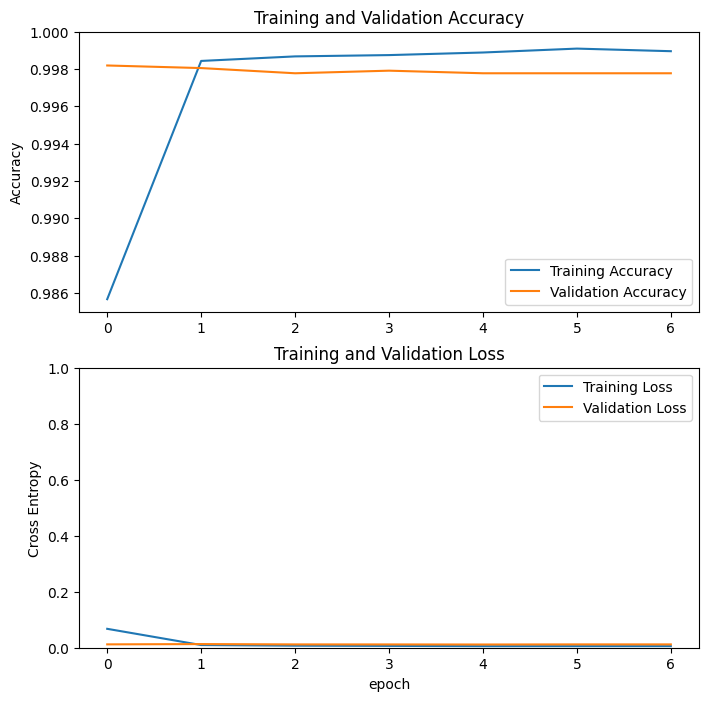

In [30]:
learning_curve(history)

## 5.Can we identify the Fake news only by using titles?

The LSTM model using GloVe embeddings was able to identify fake news from articles with an accuracy of 99.8%. However, the main area in which fake news becomes an issue is social media, where often only the headlines of articles are disseminated. It is therefore very useful to be able to identify whether an article is fake news based on the headline alone.

In [31]:
# Apply the preprocessing function
df['processed_title'] = df.title.apply(preprocess_text)

X_title = df.processed_title
y = df.target

df.head()

,title,text,subject,date,target,processed,processed_title
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,washington reuter head conserv republican fact...,budget fight loom republican flip fiscal script
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,washington reuter transgend peopl allow first ...,militari accept transgend recruit monday pentagon
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,washington reuter special counsel investig lin...,senior republican senat mueller job
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,washington reuter trump campaign advis georg p...,fbi russia probe help australian diplomat nyt
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,reuter presid donald trump call postal servic ...,trump want postal servic charg amazon shipment


In [32]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X_title, y, test_size = 0.2, random_state = 0)

# Tokenize
tokenizer2 = Tokenizer()
tokenizer2.fit_on_texts(X_train)

word_index_title = tokenizer2.word_index

In [33]:
# Convert text data to sequences
X_train_sequences = tokenizer2.texts_to_sequences(X_train)
X_val_sequences = tokenizer2.texts_to_sequences(X_val)

# Max number of words in a sequence
max_length = max([len(text.split()) for text in df.processed_title])
embedding_dim = 150

# Padding
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_length,
                               padding="post", truncating="post")
X_val_padded = pad_sequences(X_val_sequences, maxlen=max_length,
                             padding="post", truncating="post")


# An example
print(X_train[1])
print(X_train_padded[1])

militari accept transgend recruit monday pentagon
[3766 6107  271 3105  108  535  320    1  649 2678  197    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0]


### Build the LSTM model that has the same architecture as the first model above

In [34]:
glove_emb = '/kaggle/input/glove6b300dtxt/glove.6B.300d.txt'

embedding_dim = 300
embeddings_index = {}

f = open(glove_emb)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype = 'float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix_title = np.zeros((len(word_index_title), embedding_dim))
for word, i in tokenizer2.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix_title[i] = embedding_vector

In [35]:
# Parameters
epochs = 20
lr = 0.0001

# Model
model_title = Sequential()

model_title.add(Input(shape=(max_length,)))
model_title.add(Embedding(len(word_index_title), embedding_dim,
                input_length = max_length, trainable = False))

model_title.add(Bidirectional(LSTM(128, return_sequences=True)))
model_title.add(Bidirectional(LSTM(64)))
model_title.add(Dropout(0.2))

model_title.add(Dense(256, activation='relu'))
model_title.add(Dropout(0.5))
model_title.add(Dense(2, activation='sigmoid')) # Dence = 2 because of One-hot encodings

# Set the GloVe embedding weights
model_title.layers[0].set_weights([embedding_matrix_title])

# Compile the model
from tensorflow.keras.optimizers import Adam
model_title.compile(optimizer = Adam(learning_rate = lr), 
                    loss = "binary_crossentropy", metrics = ['accuracy'])

model_title.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 27, 300)        │     3,738,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 27, 256)        │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,375,786 (16.69 MB)

 Trainable params: 637,186 (2.43 MB)

 Non-trainable params: 3,738,600 (14.26 MB)

In [36]:
%%time

model_es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = 2, restore_best_weights = True)
model_rlr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, mode = 'min')

# train the model
history_title = model_title.fit(X_train_padded, y_train_one_hot, epochs = epochs, 
                                validation_split = 0.2, callbacks = [model_es, model_rlr])

Epoch 1/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - accuracy: 0.7995 - loss: 0.4005 - val_accuracy: 0.9066 - val_loss: 0.2182 - learning_rate: 1.0000e-04
Epoch 2/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9163 - loss: 0.2050 - val_accuracy: 0.9170 - val_loss: 0.1914 - learning_rate: 1.0000e-04
Epoch 3/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9284 - loss: 0.1766 - val_accuracy: 0.9234 - val_loss: 0.1799 - learning_rate: 1.0000e-04
Epoch 4/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9378 - loss: 0.1480 - val_accuracy: 0.9197 - val_loss: 0.1866 - learning_rate: 1.0000e-04
Epoch 5/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9507 - loss: 0.1268 - val_accuracy: 0.9360 - val_loss: 0.1633 - learning_rate: 2.0000e-05
Epoch 6/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.9585 - loss: 0.1072 - val_accuracy: 0.9365 - val_loss: 0.1645 - learning_rate: 2.0000e-05
Epoch 7/20
898/898 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/ste

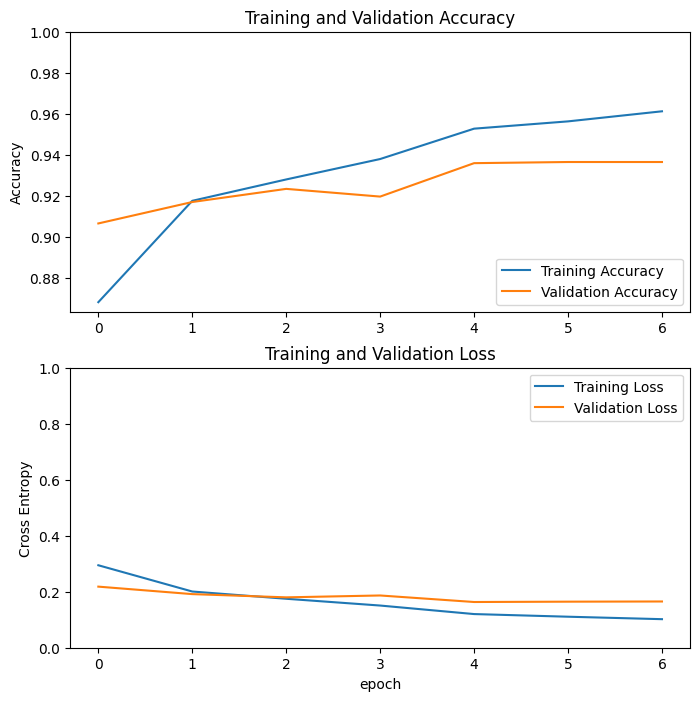

In [37]:
learning_curve(history_title)

## 6.Compatison with Convolutional Neural Network

In [38]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

X_cnn = df.processed
y = df.target

# Tokenize
tokenizer = Tokenizer(num_words=5000, lower=True, split=' ')
tokenizer.fit_on_texts(X_cnn)

# Texts to Sequences
X_seq_cnn = tokenizer.texts_to_sequences(X)

# Padding
X_pad_cnn = pad_sequences(X_seq_cnn, maxlen=300)

# Split the data
X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn = train_test_split(X_pad_cnn, y, test_size=0.2, random_state=0)

# Model
model_cnn = Sequential()

model_cnn.add(Embedding(input_dim=5000, output_dim=128, input_length=100)) # Word Embedding
model_cnn.add(Conv1D(filters=128, kernel_size=5, activation='relu')) # Convolution Layers
model_cnn.add(MaxPooling1D(pool_size=4))

model_cnn.add(GlobalMaxPooling1D())
model_cnn.add(Dropout(0.5))

model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1, activation='sigmoid'))

# Compile
model_cnn.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
history_cnn = model_cnn.fit(X_train_cnn, y_train_cnn, epochs=10, batch_size=64, validation_data=(X_test_cnn, y_test_cnn))

Epoch 1/10


I0000 00:00:1732355434.618265     101 service.cc:145] XLA service 0x7d0cc402e840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732355434.618331     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732355434.618337     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 31/562 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.5619 - loss: 0.6831

I0000 00:00:1732355437.381057     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


562/562 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.8935 - loss: 0.2231 - val_accuracy: 0.9927 - val_loss: 0.0231
Epoch 2/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9937 - loss: 0.0198 - val_accuracy: 0.9952 - val_loss: 0.0173
Epoch 3/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9972 - loss: 0.0080 - val_accuracy: 0.9949 - val_loss: 0.0165
Epoch 4/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9988 - loss: 0.0046 - val_accuracy: 0.9952 - val_loss: 0.0168
Epoch 5/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9953 - val_loss: 0.0170
Epoch 6/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9991 - loss: 0.0034 - val_accuracy: 0.9947 - val_loss: 0.0233
Epoch 7/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9993 - loss: 0.0018 - val_accuracy: 0.9948 - val_loss: 0.0198
Epoch 8/10
562/562 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9992 - loss: 0.0029 - val_accuracy: 0.9948 - va

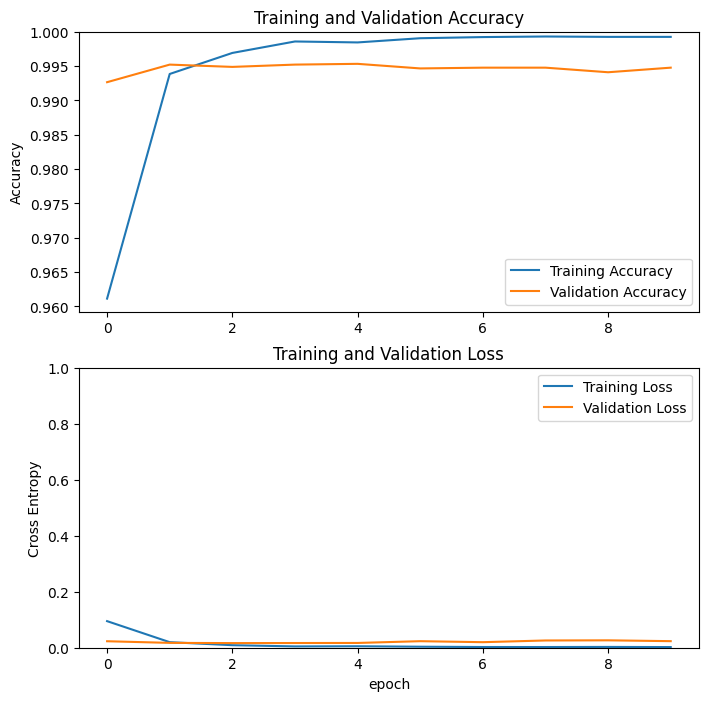

In [39]:
learning_curve(history_cnn)

## 7.Conclusion

To detect fake news, I used two models, the LSTM model with GloVe Embeddings and the CNN model. The results showed that both models were able to distinguish between fake and real news with over 99% accuracy.

I also conducted an experiment to detect fake news using only the headlines of articles, and was able to achieve a high enough accuracy rate of 93%. Although the accuracy was still superior when using text-based training data, it can be said that a web application using the headline-based model would be sufficiently useful because fake news can spread on social media even with just the headline.